In [28]:
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
import tensorflow as tf

from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import log_loss, cohen_kappa_score, matthews_corrcoef, brier_score_loss,accuracy_score

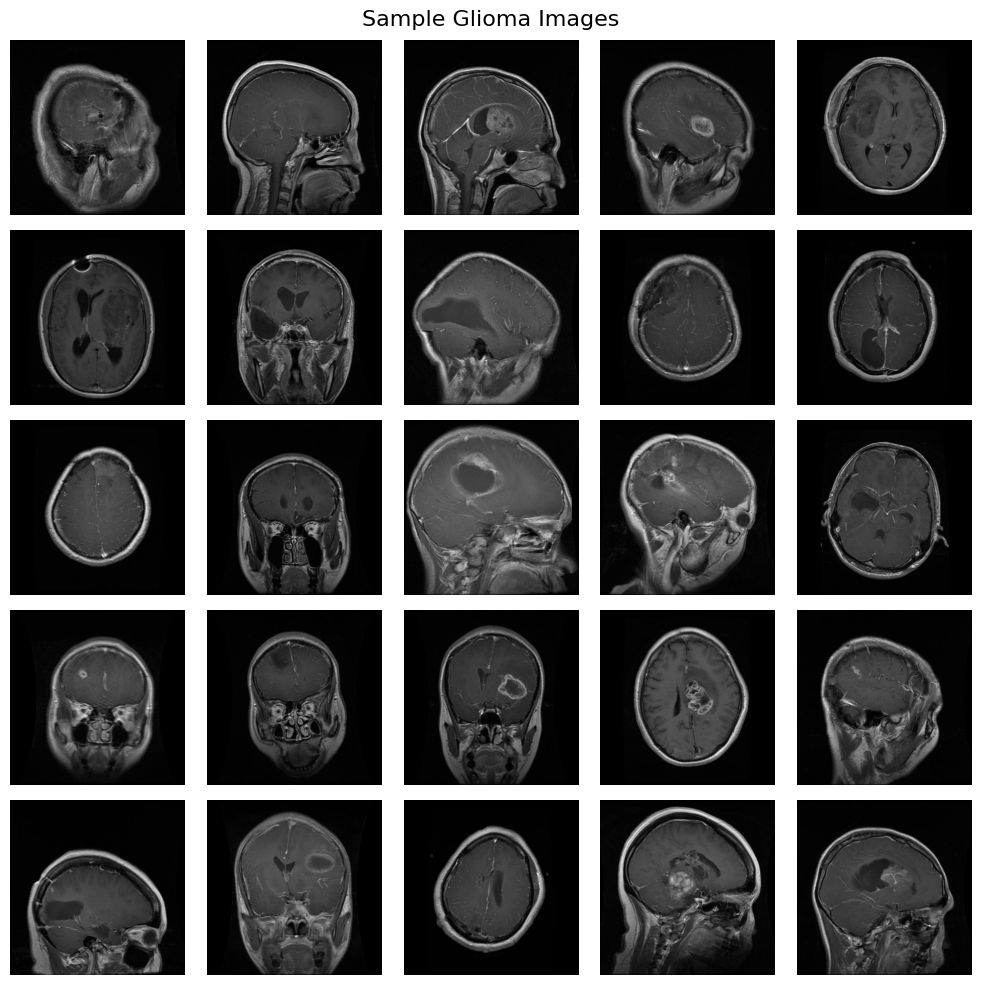

In [29]:
glioma = "/kaggle/input/brain-tumor-mri-dataset/Training/glioma/"
image_files = os.listdir(glioma)

plt.figure(figsize=(10, 10))

for i in range(25):
    img_path = os.path.join(glioma, image_files[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle('Sample Glioma Images', fontsize=16)
plt.tight_layout()
plt.show()

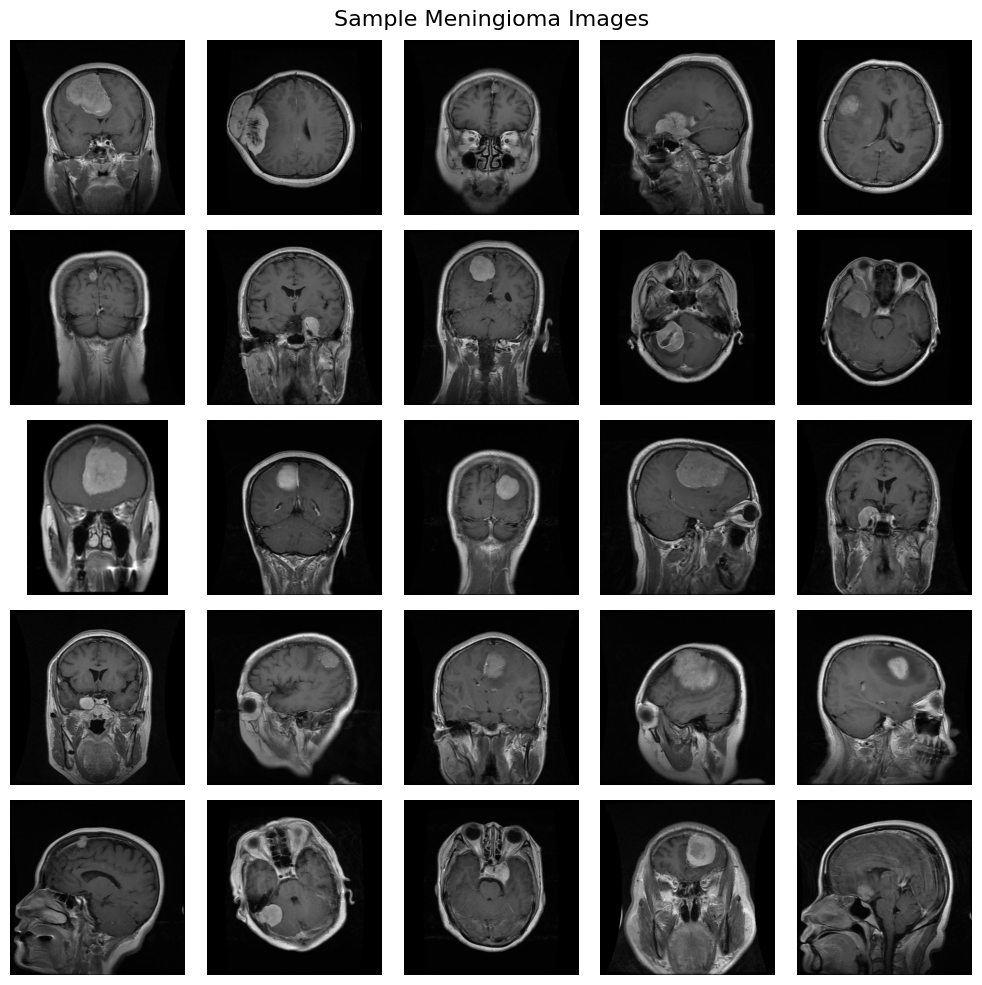

In [30]:
meningioma_dir = "/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/"
image_files = os.listdir(meningioma_dir)

plt.figure(figsize=(10, 10))

for i in range(25):
    img_path = os.path.join(meningioma_dir, image_files[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle('Sample Meningioma Images', fontsize=16)
plt.tight_layout()
plt.show()

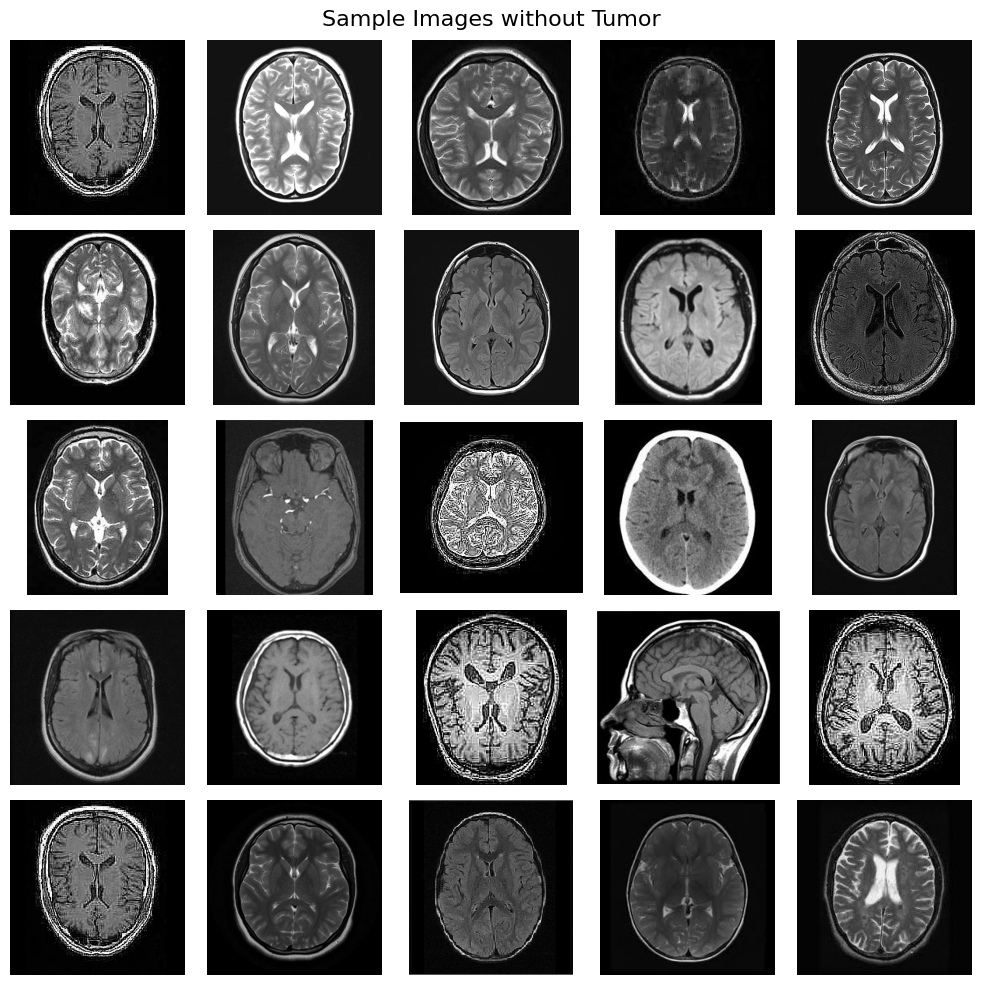

In [31]:
notumor_dir = "/kaggle/input/brain-tumor-mri-dataset/Training/notumor/"
image_files = os.listdir(notumor_dir)

plt.figure(figsize=(10, 10))

for i in range(25):
    img_path = os.path.join(notumor_dir, image_files[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle('Sample Images without Tumor', fontsize=16)
plt.tight_layout()
plt.show()

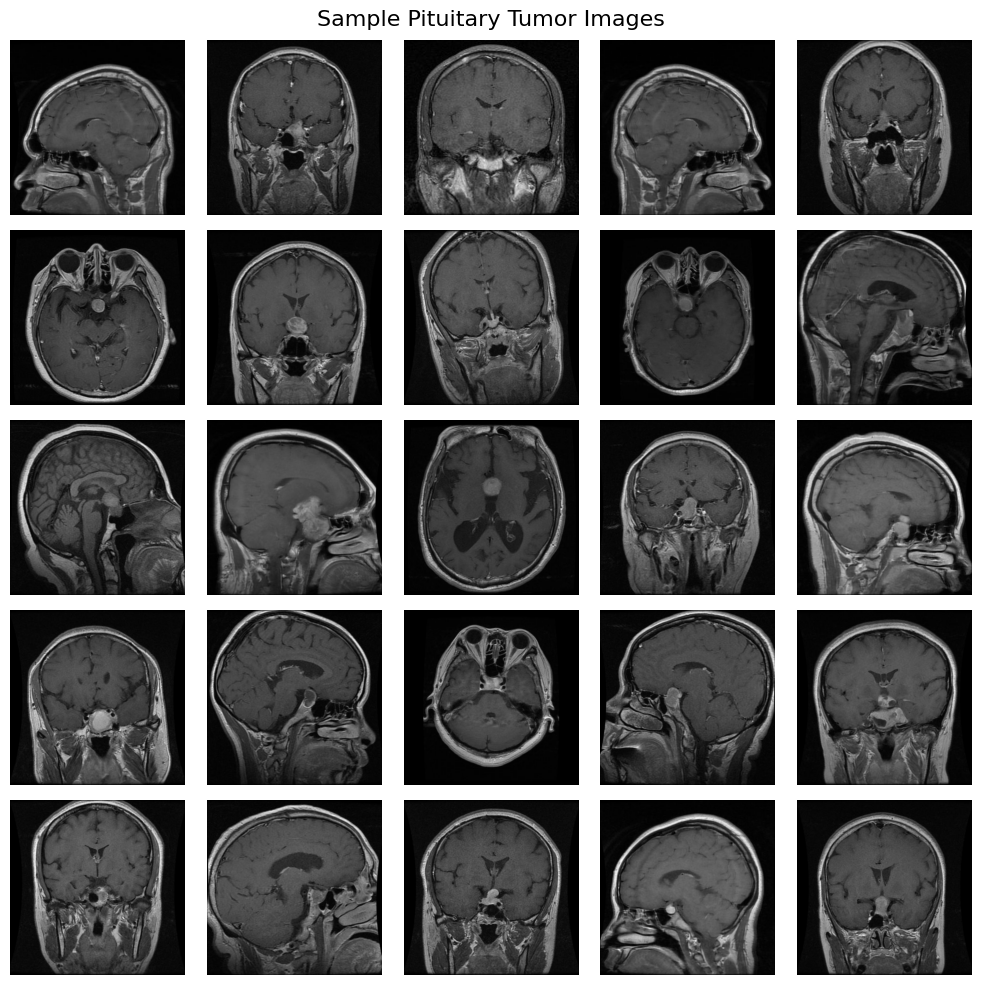

In [32]:
pituitary_dir = "/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/"
image_files = os.listdir(pituitary_dir)

plt.figure(figsize=(10, 10))

for i in range(25):
    img_path = os.path.join(pituitary_dir, image_files[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle('Sample Pituitary Tumor Images', fontsize=16)
plt.tight_layout()
plt.show()

In [33]:
image_size = [150,150]
train_data = "/kaggle/input/brain-tumor-mri-dataset/Training/"
test_data = "/kaggle/input/brain-tumor-mri-dataset/Testing/"
valid_data = "/kaggle/input/brain-tumor-mri-dataset/Testing/"

In [34]:
# Training data files

filepath=[]
label=[]
image_folder=os.listdir(train_data)

for folder in image_folder:
    folder_path=os.path.join(train_data,folder) # get folder
    filelist=os.listdir(folder_path) # get list of files in folder
    #print(f"folder_path = {folder_path}")
    for file in filelist:
        new_path=os.path.join(folder_path,file) # get file in folder path
        filepath.append(new_path)
        label.append(folder)

# create Pandas Series with list of files in 'filepath' and labels in 'label'
image_data=pd.Series(filepath,name="image_data")
label_data=pd.Series(label,name="label")

# create train dataframe 
train_df=pd.concat([image_data,label_data],axis=1)
train_df.head()

image_data      label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary

In [35]:
train_df.describe()

image_data    label
count                                                5712     5712
unique                                               5712        4
top     /kaggle/input/brain-tumor-mri-dataset/Training...  notumor
freq                                                    1     1595

In [36]:
train_df.shape

(5712, 2)

In [37]:
train_df.isnull().sum()

image_data    0
label         0
dtype: int64

In [38]:
train_df['label'].value_counts()

label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

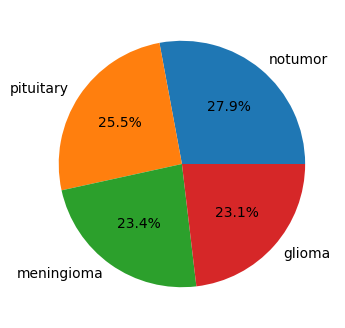

In [39]:
labels = train_df["label"].value_counts().index
sizes = train_df["label"].value_counts().values

fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

In [40]:
# Test data files

filepath=[]
label=[]
image_folder=os.listdir(test_data)

for folder in image_folder:
    folder_path=os.path.join(test_data,folder)
    filelist=os.listdir(folder_path)
    for file in filelist:
        new_path=os.path.join(folder_path,file)
        filepath.append(new_path)
        label.append(folder)
        

image_data=pd.Series(filepath,name="image_data")
label_data=pd.Series(label,name="label")
test_df=pd.concat([image_data,label_data],axis=1)
test_df.head()

image_data      label
0  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary

In [41]:
test_df.describe()

image_data    label
count                                                1311     1311
unique                                               1311        4
top     /kaggle/input/brain-tumor-mri-dataset/Testing/...  notumor
freq                                                    1      405

In [42]:
test_df.shape

(1311, 2)

In [43]:
test_df.isnull().sum()

image_data    0
label         0
dtype: int64

In [44]:
test_df['label'].value_counts()

label
notumor       405
meningioma    306
pituitary     300
glioma        300
Name: count, dtype: int64

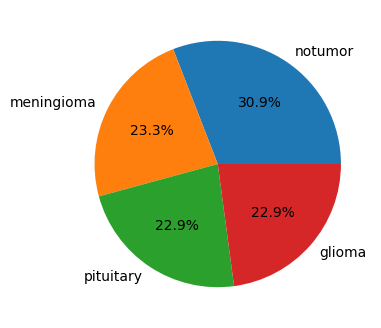

In [45]:
labels = test_df["label"].value_counts().index
sizes = test_df["label"].value_counts().values

fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

In [46]:
# Validation data files

filepath=[]
label=[]
image_folder=os.listdir(valid_data)

for folder in image_folder:
    folder_path=os.path.join(valid_data,folder)
    filelist=os.listdir(folder_path)
    for file in filelist:
        new_path=os.path.join(folder_path,file)
        filepath.append(new_path)
        label.append(folder)
        

image_data=pd.Series(filepath,name="image_data")
label_data=pd.Series(label,name="label")
valid_df=pd.concat([image_data,label_data],axis=1)
valid_df.head()

image_data      label
0  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary

In [47]:
valid_df.describe()

image_data    label
count                                                1311     1311
unique                                               1311        4
top     /kaggle/input/brain-tumor-mri-dataset/Testing/...  notumor
freq                                                    1      405

In [48]:
valid_df.shape

(1311, 2)

In [49]:
valid_df.isnull().sum()

image_data    0
label         0
dtype: int64

In [50]:
valid_df['label'].value_counts()

label
notumor       405
meningioma    306
pituitary     300
glioma        300
Name: count, dtype: int64

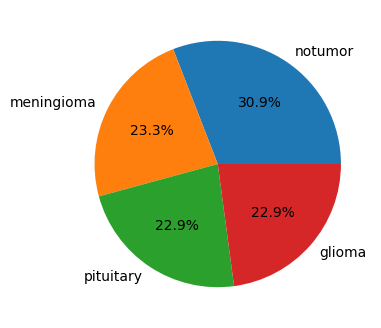

In [51]:
labels = valid_df["label"].value_counts().index
sizes = valid_df["label"].value_counts().values

fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

In [52]:
train_counts = train_df.value_counts().sum()
test_counts = test_df.value_counts().sum()
valid_counts = valid_df.value_counts().sum()

print(train_counts,test_counts,valid_counts)

5712 1311 1311


# Data Augmentation for images

ImageDataGenerator is a class in tensorflow.keras.preprocessing.image that provides various data augmentation techniques for images. It generates batches of tensor image data with real-time data augmentation, which can help prevent overfitting and improve the generalization of your model.

Key Features:

**Data Augmentation:**

- Randomly rotating images
- Randomly shifting images horizontally and vertically
- Randomly flipping images horizontally
- Randomly zooming inside images
- Adjusting the brightness of images
- Shearing images

**Data Normalization:**

- Rescaling pixel values
- Standardizing pixel values to have a mean of 0 and a standard deviation of 1

**Real-Time Data Generation:**

- Generates batches of tensor image data with real-time data augmentation. This means that the images are augmented on the fly while your model is training.

In this example, the ImageDataGenerator is configured to apply various augmentations to the images, such as rotation, shifting, shearing, and zooming. The flow method is used to generate augmented images in batches.

This approach can significantly enhance the diversity of your training data, leading to better model performance and generalization.

**"flow_from_dataframe"**

The flow_from_dataframe method generates batches of tensor image data from the pandas dataframe, **which should contain the paths to the images and optionally, the corresponding labels**. This method is especially useful when your dataset is too large to fit into memory and is stored in a directory with paths referenced in a dataframe.

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=16           # images to be yielded from the generator per batch
color_channel=3         # images in RGB format (3 channels: Red, Green, Blue).
image_shape=(150,150,3) # shape of the input images: 150 pixels height, 150 pixels width, and 3 color channels

# Train generator (augmented)
train_generator = ImageDataGenerator(
    rescale=1.0/255,    # rescales the pixel values: from range [0, 255] to [0, 1]. (normalize the image data)
    rotation_range=20,  # randomly rotates the image within [0, rotation_range]. (model invariant to rotations)
    width_shift_range=0.1,  # randomly shifts the image horizontally by 10% width. (translation invariant)
    height_shift_range=0.1, # randomly shifts the image vertically by 10% height. (translation invariant)
    shear_range=0.2,        # random shearing, tilts the image along the x or y axis, creating a "slanting" effect.
    zoom_range=0.2,         # randomly zooms in or out on the image by up to 20%. (zoom invariant)
    horizontal_flip=True,   # randomly flips the image. if orientation is not important. (mirror invariant, parity)
    fill_mode='nearest'     # how newly created pixels are filled in when the image is transformed. (nearest pixel here)
)    

# Test generator (not augmented)
test_generator = ImageDataGenerator(rescale=1./255)


train_data_generator = train_generator.flow_from_dataframe(train_df, # image paths and labels
                                                        x_col="image_data", # column in df with the filenames 
                                                        y_col="label",      # column in df with the labels 
                                                        target_size=image_size, # all images resized (we defined image_size=[150,150])
                                                        color_mode="rgb",
                                                        shuffle=True, # shuffle images and labels (ensures model doesnt learn the order of the data)
                                                        batch_size=batch_size)

test_data_generator = test_generator.flow_from_dataframe(test_df,
                                                        x_col="image_data",
                                                        y_col="label",
                                                        target_size=image_size,
                                                        color_mode="rgb",
                                                        shuffle=False, # no shuffle
                                                        batch_size=batch_size)

valid_data_generator = test_generator.flow_from_dataframe(valid_df,
                                                        x_col="image_data",
                                                        y_col="label",
                                                        target_size=image_size,
                                                        color_mode="rgb",
                                                        shuffle=True, # yes shuffle (valid_df used during training to evaluate the model's performance)
                                                        batch_size=batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


# Creating the DenseNet-169 Model

Image taken from: Abdalla, P.A., Mohammed, B.A. & Saeed, A.M. The impact of image augmentation techniques of MRI patients in deep transfer learning networks for brain tumor detection. Journal of Electrical Systems and Inf Technol 10, 51 (2023). https://doi.org/10.1186/s43067-023-00119-9

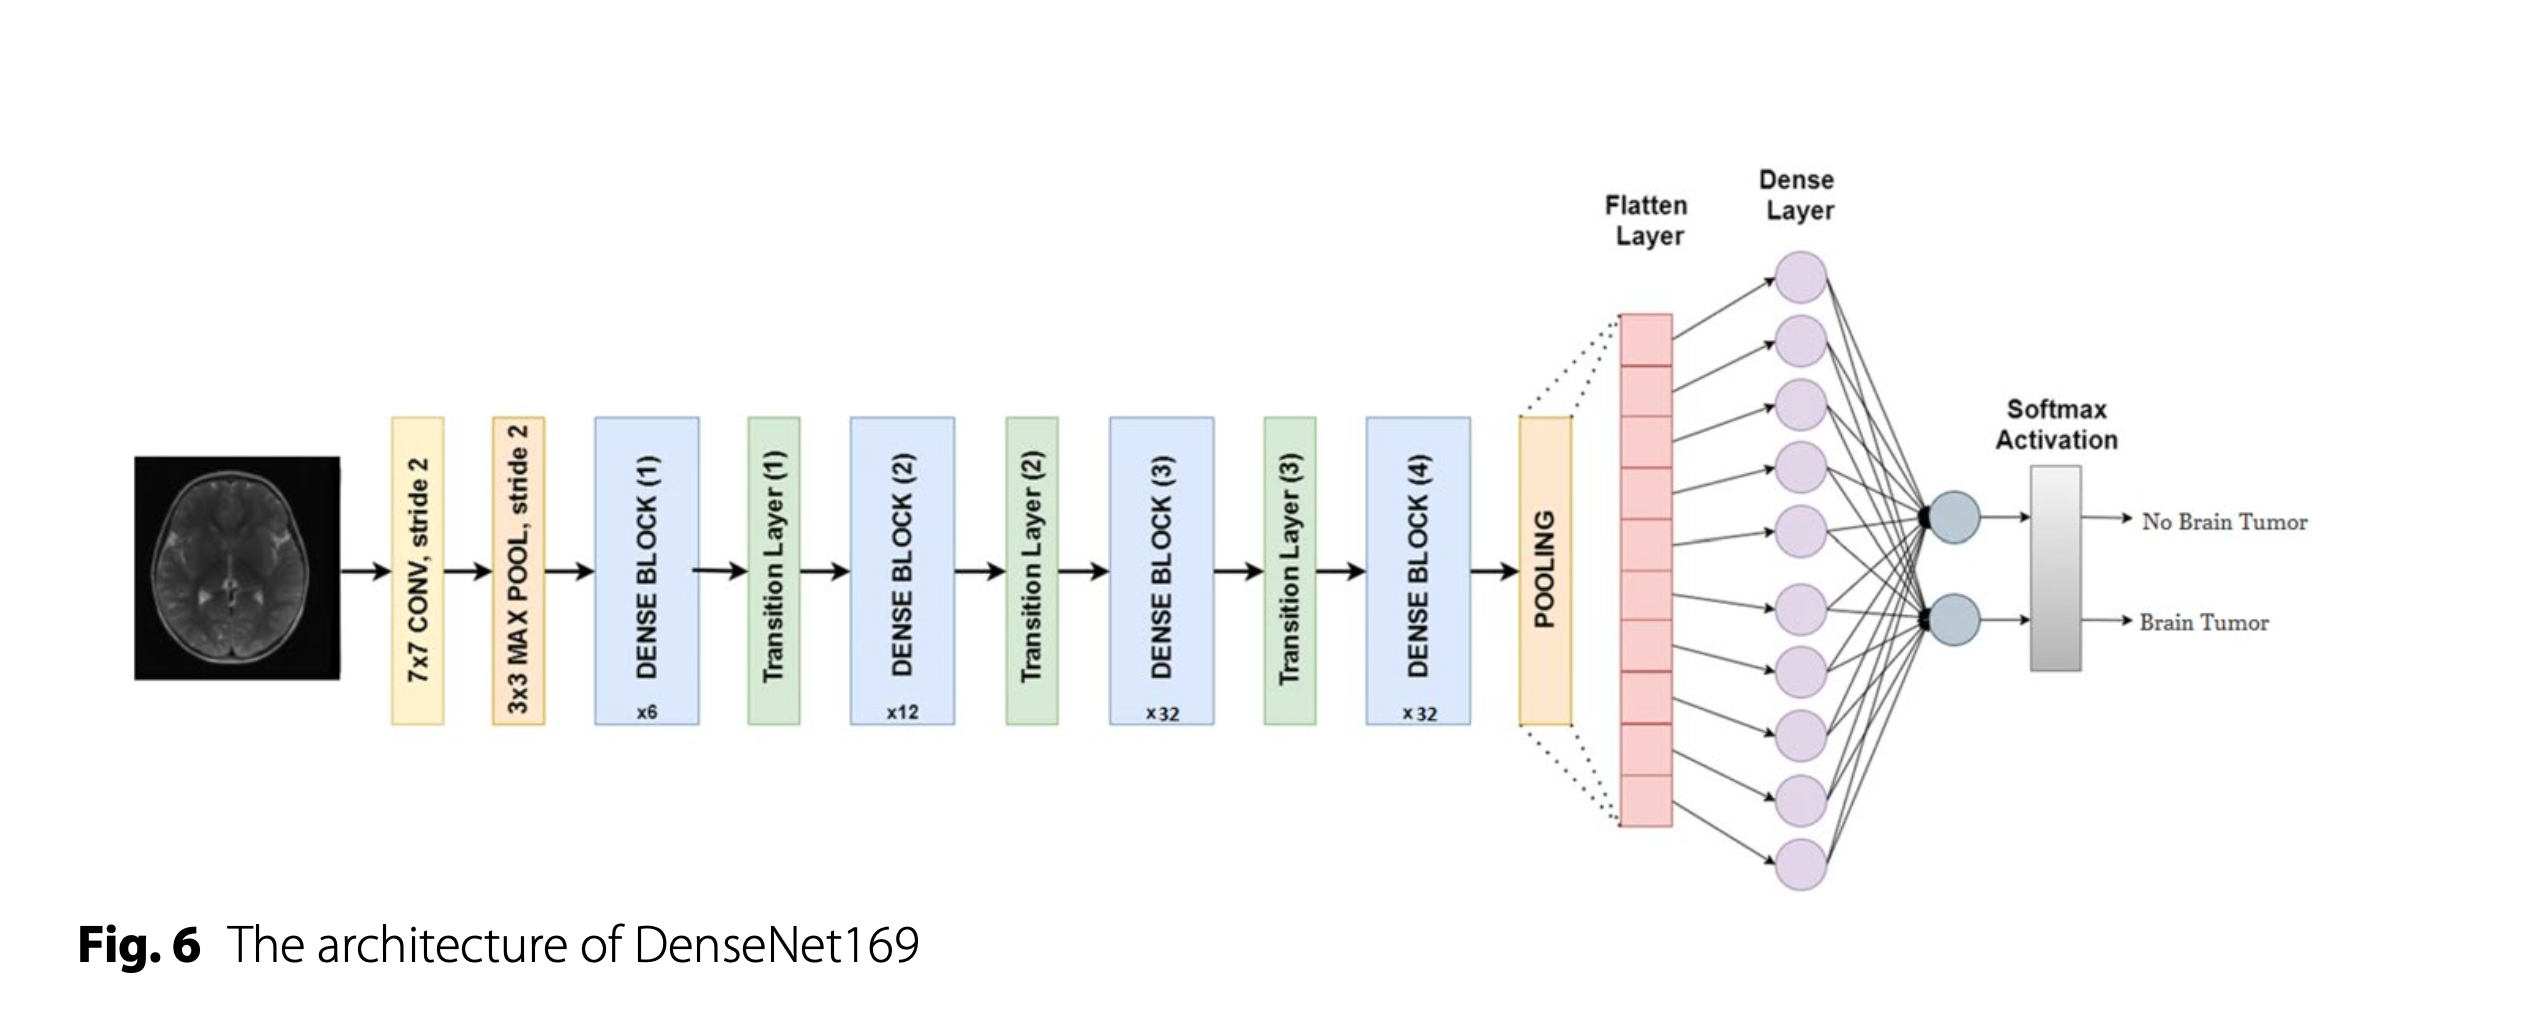

In [54]:
## setup params
batch_size = 16 
image_shape = (150, 150, 3) # (pixels hight, pixels witdh, color channels)

## creating the DenseNet-169 Model
def create_densenet169_model(input_shape, num_classes):

    # loads the DenseNet-169 model pre-trained on ImageNet dataset
    # without including the top (classification) layers and sets the input shape for the model
    # initialize model DenseNet169
    base_model = DenseNet169(weights = 'imagenet', # use pre-trained weights
                             include_top = False,  # remove final fully connected layer (specific to the ImageNet classification task)
                             input_shape = input_shape)

    # Customizing the top layers to suit our specific dataset and classification requirements
    x = base_model.output     
    # Customizing Model. Feature Extraction Layers:
    x = GlobalAveragePooling2D()(x) # applies global average pooling to reduce the spatial dimensions of the feature maps from the base model
    x = Dense(1024, activation='relu')(x) # adds a fully connected layer with 1024 units and ReLU activation function to further process the features
    
    # Output Layer:
    predictions = Dense(num_classes, activation='softmax')(x)  # adds a dense layer with softmax for multi-class classification

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze layers of the pre-trained model (on ImageNet), prevents weights from being updated during training.
    # The pre-trained model, like DenseNet-169, is usually trained on a large, generic dataset (ImageNet).
    # -> Fine-tuning helps adapt the model to new, specific characteristics
    for layer in base_model.layers:
        layer.trainable = False

    return model

## compiling the model
num_classes = len(train_data_generator.class_indices) # num_classes is the number of classes in our dataset
model = create_densenet169_model(image_shape, num_classes) # instantiate and configure DenseNet-169 model
model.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [55]:
## sumary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 156, 156,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 38, 38,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 38, 38,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 38, 38,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 38, 38,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 38, 38,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 38, 38,    │     12,288 │ conv2_block2_0_r

 Total params: 14,351,940 (54.75 MB)

 Trainable params: 1,709,060 (6.52 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [56]:
## Callbacks setup

# 1) Monitors the validation loss during training and stops the training process early if the validation loss stops improving.
early_stopping = EarlyStopping(
    monitor='val_loss', # metric to monitor
    patience=10, # number of epochs to wait before stopping training after no improvement
    restore_best_weights=True # restores the model weights from the epoch with the best monitored metric value after training
)

# 2) Reduces the learning rate (LR) when the monitored metric (val_loss) has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, # if no improvement is seen for patience epochs, the learning rate is multiplied by factor
    patience=10, 
    min_lr=1e-6 # lower bound
)

## Model Training
# Trains the model (model) on the training data (train_data_generator) and evaluates its performance on the validation data (valid_data_generator)
history = model.fit(
    train_data_generator, # generator providing batches of training data
    validation_data=valid_data_generator, # generator providing batches of validation data for evaluation during training
    epochs=50, # typical starting range is 10-50 epochs for initial experimentation
    callbacks=[early_stopping, reduce_lr] # list of callback functions, used to monitor and adjust training based on validation loss
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 308s 801ms/step - accuracy: 0.7509 - loss: 0.7446 - val_accuracy: 0.8360 - val_loss: 0.4164 - learning_rate: 0.0010
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 276s 769ms/step - accuracy: 0.8839 - loss: 0.3165 - val_accuracy: 0.8200 - val_loss: 0.4461 - learning_rate: 0.0010
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 317s 756ms/step - accuracy: 0.8906 - loss: 0.2804 - val_accuracy: 0.8772 - val_loss: 0.3678 - learning_rate: 0.0010
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 277s 773ms/step - accuracy: 0.9018 - loss: 0.2607 - val_accuracy: 0.8986 - val_loss: 0.2750 - learning_rate: 0.0010
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 279s 779ms/step - accuracy: 0.9205 - loss: 0.2223 - val_accuracy: 0.8871 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 6/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 277s 773ms/step - accuracy: 0.9105 - loss: 0.2395 - val_accuracy: 0.9230 - val_loss: 0.2219 - learning_rate: 0.0010
Epoch 7/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 279s 778ms/step - accuracy: 0.9235 

# Fine-tuning (optional)

Fine-tuning training starts where the previous (initial) training left off, rather than starting again from scratch. Here’s how it works:

- Continuity: Fine-tuning starts from the weights learned during the initial training phase. The model does not reset to its initial state; instead, it builds upon the knowledge gained from the initial training.

- Purpose: The goal of fine-tuning is to refine the model’s representations to better fit your specific task while leveraging the general features learned from a large dataset (ImageNet in this case).

- Performance: Fine-tuning often improves model performance on the specific task compared to training from scratch, especially when the initial dataset is limited or when there’s a significant domain shift.

In [ ]:
# Fine-tuning setup (unfreeze some layers and recompile)
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',   # Same loss function as initial training
    metrics=['accuracy']                # Same metrics as initial training
)

# Continue training with fine-tuning
fine_tune_history = model.fit(
    train_data_generator,       # Same training generator
    validation_data=valid_data_generator,  # Same validation generator
    epochs=50,                  # Number of epochs for fine-tuning
    callbacks=[early_stopping, reduce_lr]  # Same callbacks for monitoring and adjusting training
)

# Model Loss

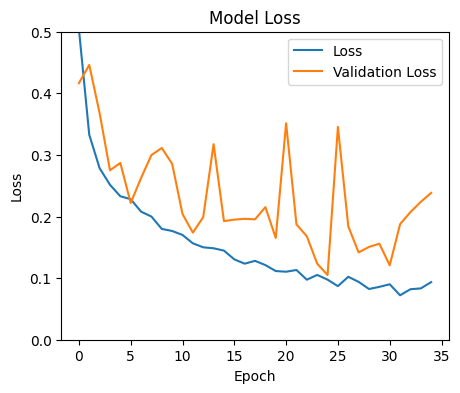

In [66]:
# Plotting Loss and Validation Loss for initial training
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")

# Plotting Loss and Validation Loss for fine-tuning
if 'fine_tune_history' in locals():  # Check if fine_tune_history exists
    plt.plot(fine_tune_history.history['loss'], label="Fine-tuning Loss")
    plt.plot(fine_tune_history.history['val_loss'], label="Fine-tuning Validation Loss")

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.0,0.5)
plt.legend()
plt.show()

# Model Accuracy

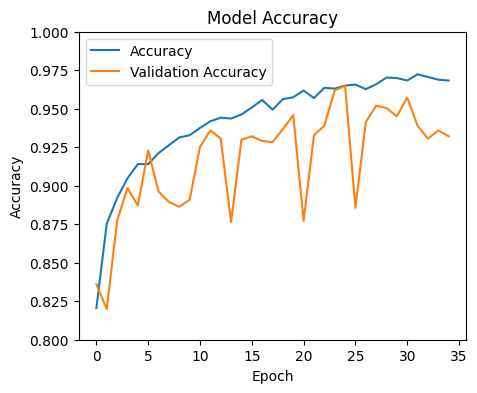

In [68]:
# Plotting Accuracy and Validation Accuracy for initial training
plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")

# Plotting Accuracy and Validation Accuracy for fine-tuning
if 'fine_tune_history' in locals():  # Check if fine_tune_history exists
    plt.plot(fine_tune_history.history['accuracy'], label="Fine-tuning Accuracy")
    plt.plot(fine_tune_history.history['val_accuracy'], label="Fine-tuning Validation Accuracy")

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8,1.0)
plt.legend()
plt.show()

What to look for in a plot of the training and validation accuracy?
====

When we analyze a plot of training and validation accuracy as a function of epochs during the training of a machine learning model, there are several key aspects to consider:

**Training Accuracy Trend:**

- Increase Over Epochs: Ideally, the training accuracy should increase steadily over epochs, indicating that the model is learning and improving its predictions on the training data.

- Plateau or Fluctuations: Occasional fluctuations or a plateau may occur, especially towards the later epochs as the model converges. This is normal, but if the training accuracy stops improving early on, it might indicate issues like underfitting or insufficient model complexity.

**Validation Accuracy Trend:**

- Increase and Plateau: Initially, the validation accuracy tends to increase as the model learns from the training data. It should ideally plateau or stabilize after a certain number of epochs.

- Gap with Training Accuracy: Typically, validation accuracy lags behind training accuracy but should closely track it. A significant gap (especially widening) might suggest overfitting.

**Relative Magnitudes:**

- Training vs. Validation: Compare the magnitudes of training and validation accuracies. The training accuracy is expected to be higher because the model is directly optimized on this data. However, if the validation accuracy significantly lags behind (especially after stabilization), it might indicate overfitting.

- Consistency: Look for consistency and stability in both curves after the initial epochs. Large oscillations or erratic behavior could suggest instability in training.

**Early Stopping Point:**

- Optimal Epochs: Identify where the validation accuracy peaks or plateaus. This point can indicate when to stop training to prevent overfitting. Early stopping techniques often use validation accuracy as a criterion to determine when further training is no longer beneficial.

**Learning Rate Analysis:**

- Impact of Learning Rate: Sudden drops or jumps in accuracy trends could indicate issues with learning rate adaptation during training. Learning rate schedules and adaptive methods (like Adam optimizer) can help mitigate this.

**Generalization and Overfitting:**

- Gap Between Training and Validation: Monitor how closely the validation accuracy tracks the training accuracy. A widening gap suggests overfitting, where the model is memorizing the training data rather than generalizing from it.

**Smoothness of Curves:**

- Smooth Convergence: Ideally, both training and validation accuracy curves should show smooth convergence without large spikes or drops, especially towards the end of training.

**Interpretation Example**

- Ideal Case: Both training and validation accuracies steadily increase and eventually plateau at high values, indicating the model has learned to generalize well.

- Overfitting: Training accuracy continues to increase while validation accuracy stagnates or declines after an initial rise, indicating the model has memorized training examples.

- Underfitting: Both accuracies plateau at low values, suggesting the model is not complex enough to capture the underlying patterns in the data.

In summary, the plot of training and validation accuracy over epochs provides critical insights into the learning dynamics and generalization ability of our model. It helps in optimizing training strategies, diagnosing issues like overfitting or underfitting, and making informed decisions about model improvements.

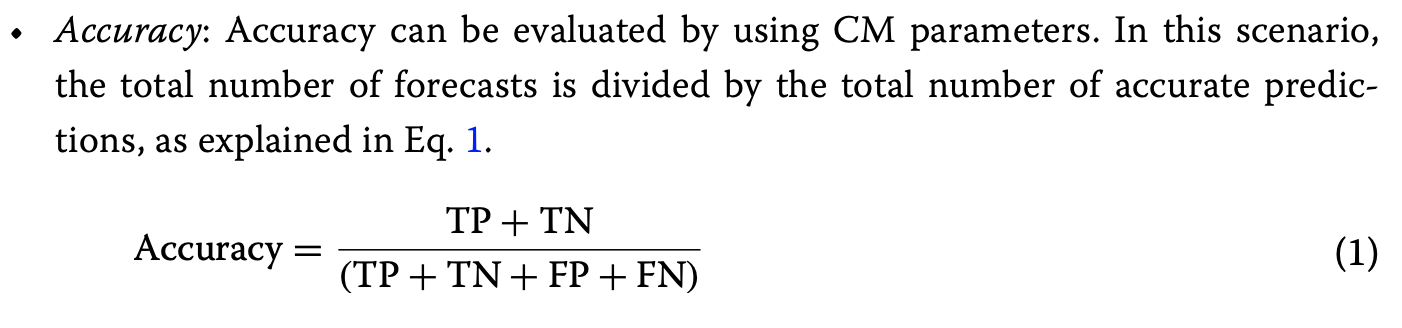

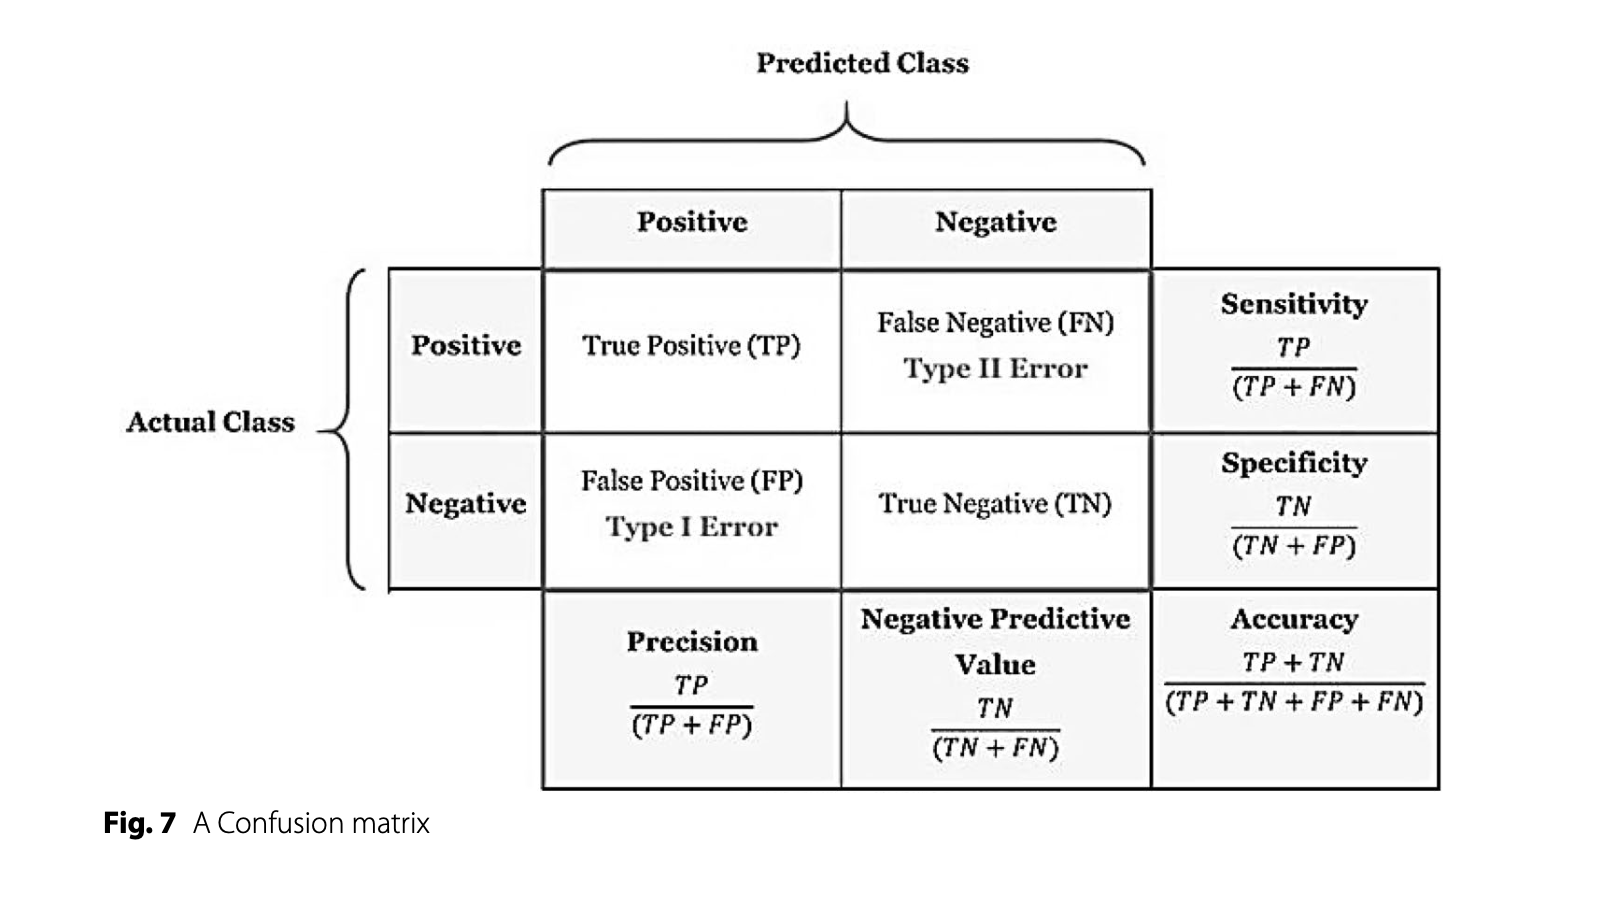

# Save the model

In [63]:
# Save the entire model to a HDF5 file
model.save('brain_tumor_classifier.h5')

# Assess model's performance on Test (unseen) data

In [64]:
test_loss, test_accuracy = model.evaluate(test_data_generator) # evaluates the model on the provided test data generator
print(f'Test Loss: {test_loss:.4f}') # computed loss value on the test dataset
print(f'Test Accuracy: {test_accuracy:.4f}') # computed accuracy value on the test dataset

82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 582ms/step - accuracy: 0.9813 - loss: 0.0655
Test Loss: 0.1050
Test Accuracy: 0.9649


In [69]:
test_data_generator.class_indices # one-hot encoding

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [72]:
label_name=["glioma","meningioma","notumor","pituitary"] # our labels

#  Generate predictions and extract the predicted class labels


In [73]:
# example: if pred=[0.1,0.3,0.8,0.01] then final=[0,0,1,0]

pred = model.predict(test_data_generator) # array where each row corresponds to a sample and each column corresponds to a class probability 
final = np.argmax(pred,axis=1) # converts probabilities into class labels by selecting the class w/ the highest predicted probability 

82/82 ━━━━━━━━━━━━━━━━━━━━ 60s 662ms/step


# Confusion Matrix

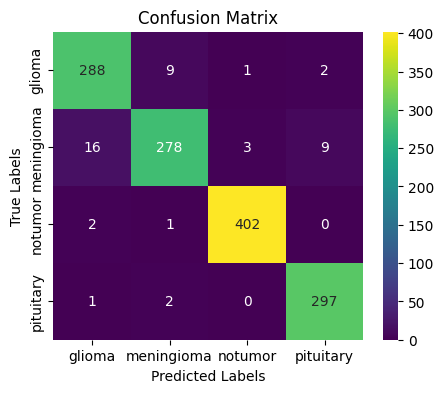

In [79]:
# confusion_matrix computes a confusion matrix based on the true labels (true_data) and the predicted labels (final). 
# It compares how many samples from each class were correctly predicted and how many were confused with other classes.

true_data = test_data_generator.classes # true labels
cf = confusion_matrix(true_data, final) 

plt.figure(figsize=(5,4))
sns.heatmap(cf, annot=True, cmap='viridis', fmt='g', xticklabels = label_name, yticklabels = label_name)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report

In [80]:
print(
    classification_report(true_data, final, target_names = label_name)
)

              precision    recall  f1-score   support

      glioma       0.94      0.96      0.95       300
  meningioma       0.96      0.91      0.93       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



# ROC curve

**Receiving Operating Characteristic (ROC)**

**ROC Curve Construction:**

- The ROC curve plots TPR (sensitivity) against FPR (1 - specificity) at various threshold settings.
- Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular threshold.
- A diagonal line from (0,0) to (1,1) represents random guessing (no discrimination ability).
- The ideal classifier would have a curve that passes through (0,1) and then up the left side to (1,1).

**Area Under the Curve (AUC):**

- The AUC quantifies the overall performance of the classifier.
- AUC ranges from 0 to 1, where a value closer to 1 indicates **better performance**.
- An AUC of 0.5 suggests that the classifier performs **no better than random**.

82/82 ━━━━━━━━━━━━━━━━━━━━ 50s 611ms/step


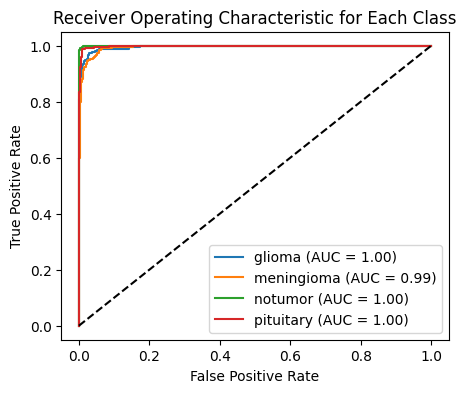

In [82]:
y_true = test_data_generator.classes
y_pred_prob = model.predict(test_data_generator)


classes = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
y_true_binarized = label_binarize(y_true, classes=range(len(classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_true_binarized[:, i], y_pred_prob[:, i])

plt.figure(figsize=(5, 4))
for i, label in enumerate(classes.keys()):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend()
plt.show()

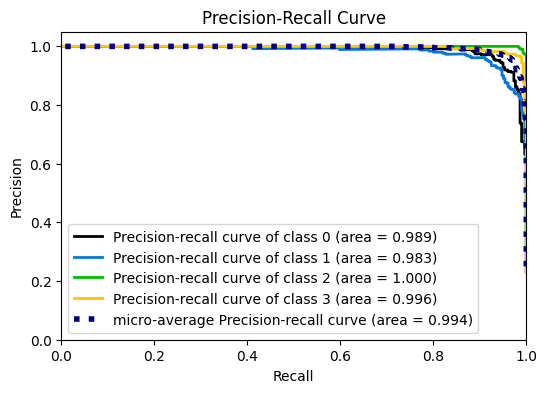

In [85]:
import scikitplot as skplt

skplt.metrics.plot_precision_recall(y_true, y_pred_prob,figsize=(6,4))
plt.show()

In [86]:
acc_score = accuracy_score(y_true,final)
print(f'Accuracy Score  Score: {acc_score:.4f}')

roc_auc = roc_auc_score(y_true, pred,multi_class='ovr')
print(f'ROC AUC  Score: {roc_auc:.4f}')

logarithm_loss=log_loss(y_true,pred)
print(f'Log Loss: {logarithm_loss:.4f}')

kappa = cohen_kappa_score(y_true,final)
print(f'Cohen Kappa Score: {kappa:.4f}')

mcc = matthews_corrcoef(y_true, final)
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

num_classes=4
true_data_one_hot = np.eye(num_classes)[true_data]
brier_scores = []
for i in range(num_classes):
    brier_scores.append(brier_score_loss(true_data_one_hot[:, i], pred[:, i]))
average_brier_score = np.mean(brier_scores)
print(f' Average Brier Score Loss: {mcc:.4f}')

Accuracy Score  Score: 0.9649
ROC AUC  Score: 0.9973
Log Loss: 0.1050
Cohen Kappa Score: 0.9529
Matthews Correlation Coefficient: 0.9531
 Average Brier Score Loss: 0.9531


# True vs Predicted

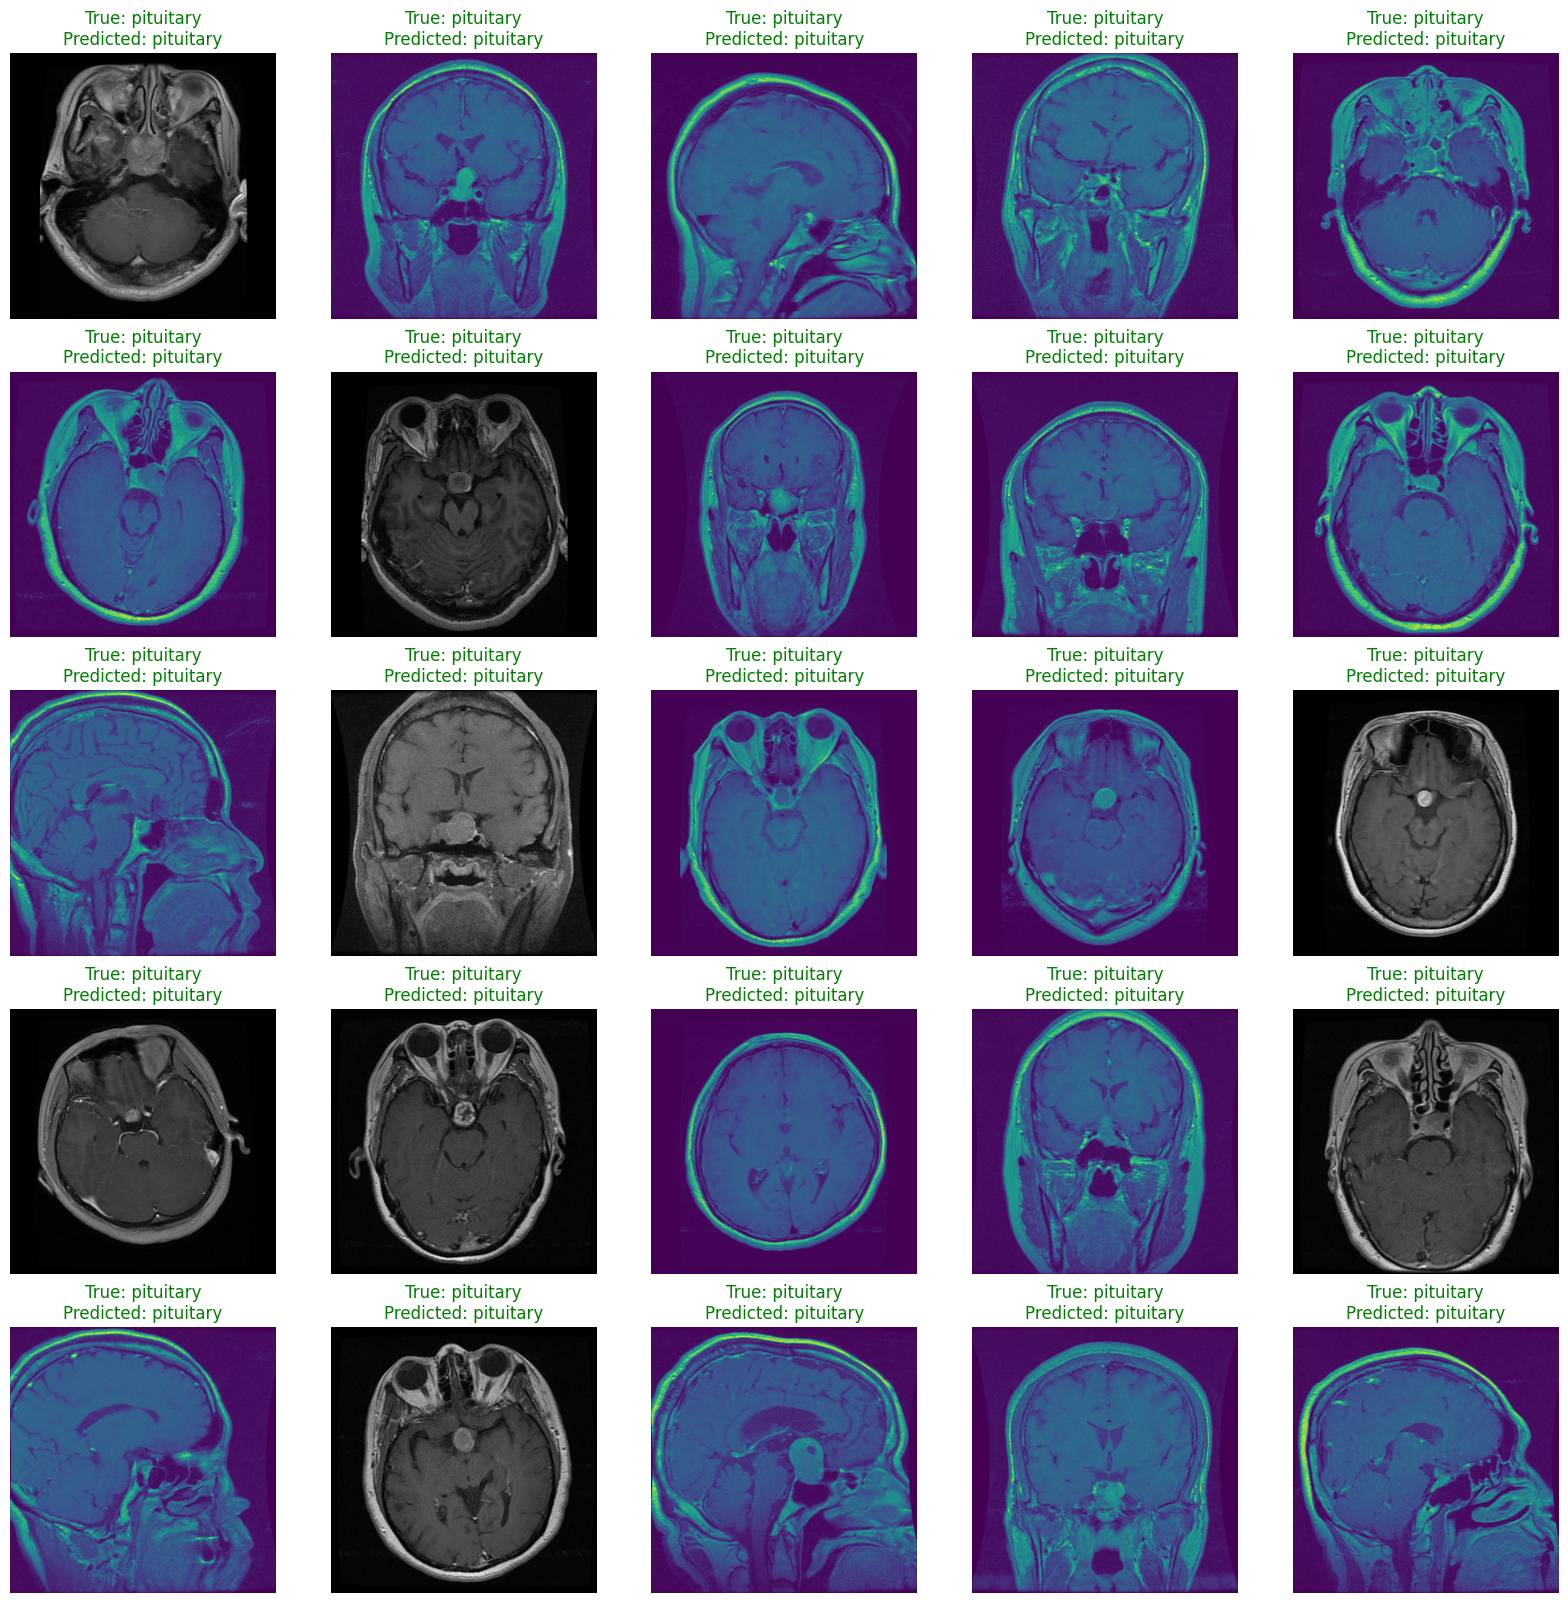

In [93]:
class_name = list(test_data_generator.class_indices.keys())

plt.figure(figsize=(20,20))
number_images=(5,5)
for i in range(1,(number_images[0]*number_images[1])+1):
    plt.subplot(number_images[0],number_images[1],i)
    plt.axis("off")
    
    true_label = class_name[test_data_generator.classes[i]]
    predicted_label = class_name[final[i]]
    
    color="green"
    if true_label != predicted_label:
        color="red"
    
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)
    plt.imshow(plt.imread(test_data_generator.filepaths[i]))
plt.show()